In [1]:
from google.colab import drive
drive.mount('/content/drive')
drivePath = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [2]:
SEED = 1234

import torch
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Download dataset from official website

In [3]:
#@title Download CoNSeP
!rm -rf CoNSeP
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
!unzip /content/consep.zip > /dev/null
!rm -rf _*; rm /content/consep.zip

--2021-07-01 09:29:09--  https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  19.6MB/s    in 7.8s    

2021-07-01 09:29:17 (18.7 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [4]:
import os
import scipy.io
import numpy as np
from PIL import Image

In [5]:
#@title view labels and images
# mat = scipy.io.loadmat('/content/CoNSeP/Train/Labels/train_1.mat')

import matplotlib.pyplot as plt

# H = mat['inst_map']

# plt.imshow(H, interpolation='none')
# plt.show()

# H = mat['type_map']

# plt.imshow(H, interpolation='none')
# plt.show()

# image = np.array(Image.open('/content/CoNSeP/Train/Images/train_24.png'))
# H = image[:,:,3]

# plt.imshow(H, interpolation='none')
# plt.show()

# Data loaders

In [6]:
class ConsepSimpleDataset(torch.utils.data.Dataset):
  def __init__(self, train = False, test = False):
        self.directory = 'CoNSeP/Train' if train else 'CoNSeP/Test'
        self.setname = 'train' if train else 'test'
        assert train != test

  def __len__(self):
        return len(os.listdir(os.path.join(self.directory, 'Images')))

  def __getitem__(self, index):
        # Load data and get label
        image = np.array(Image.open(os.path.join(self.directory, 'Images', self.setname + f'_{index + 1}.png')))[:,:,:3]
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))) / 255

        labels = scipy.io.loadmat(os.path.join(self.directory, 'Labels', self.setname + f'_{index + 1}.mat'))
        label_inst = torch.from_numpy(labels['inst_map']).long()
        label_type = torch.from_numpy(labels['type_map']).long()

        return image, label_inst, label_type

In [7]:
# CUDA for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 0}

# Generators
training_set = ConsepSimpleDataset(train = True)
validation_len = int(len(training_set) * 0.3)

training_set, validation_set = torch.utils.data.random_split(training_set, [len(training_set) - validation_len, validation_len])
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = ConsepSimpleDataset(test = True)
test_generator = torch.utils.data.DataLoader(test_set, **params)

In [8]:
n_type = 8
ratio_type = torch.ones(n_type)
ratio_inst = torch.ones(2)
for _, local_labels_inst, local_labels_type in training_generator:
    for i in range(n_type):
        ratio_type[i] += torch.sum(local_labels_type == i)
    ratio_inst[0] += torch.sum(local_labels_inst == 0)
    ratio_inst[1] += torch.sum(local_labels_inst > 0)

# Model

In [9]:
#@title clone U-net
!rm -rf Pytorch-UNet; git clone https://github.com/milesial/Pytorch-UNet.git; mv Pytorch-UNet/unet/unet*.py ./
with open('unet_model.py', 'r') as f:
    codes = f.read()
codes = codes.replace('from .unet_parts', 'from unet_parts')
with open('unet_model.py', 'w') as f:
    f.write(codes)

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 352, done.
remote: Total 352 (delta 0), reused 0 (delta 0), pack-reused 352
Receiving objects: 100% (352/352), 47.35 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (177/177), done.


In [10]:
import torch.nn as nn
from unet_model import UNet

In [11]:
model = UNet(n_channels=3, n_classes=n_type, bilinear=True)
model = model.to(device)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,267,848 trainable parameters


# Training

In [13]:
from torch import optim

optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-8, momentum=0.9)

if n_type > 1:
    criterion = nn.CrossEntropyLoss(weight = 1 / torch.log(ratio_type).to(device))
else:
    criterion = nn.CrossEntropyLoss(weight = 1 / torch.log(ratio_inst).to(device))

In [14]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).float().mean()
    acc = correct
    return acc

In [15]:
def binary_metric(preds, y, n_classes=8):
    rounded_preds = preds.argmax(1)
    scores = []
    t = rounded_preds == y
    for i in range(n_classes):
        p = rounded_preds == i
        tp = torch.sum(torch.logical_and(t, p).float(), dim = 1)
        fp = torch.sum(torch.logical_and(torch.logical_not(t), p).float(), dim = 1)
        fn = torch.sum(torch.logical_and(torch.logical_not(t), torch.logical_not(p)).float(), dim = 1)

        recall = tp / (tp + fn + 1e-10)
        prec = tp / (tp + fp + 1e-10)
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-10)
        f2 = 5 * tp / (5 * tp + 4 * fn + fp + 1e-10)
        scores.append([recall.mean(), prec.mean(), f1.mean(), f2.mean()])
    
    return torch.tensor(scores)

In [16]:
def dice(true, pred):
    smooth = 0.001
    pred = pred.argmax(1, keepdim = True)
    m1 = pred.reshape(-1,).tolist()  
    m2 = true.reshape(-1,).tolist() 
    intersect=0 
    count1=0
    count2=0
    for i in range(0,len(m1)):
      if int(m1[i])!=0:
        count1+=1
      if int(m2[i])!=0:
        count2+=1        
      if int(m1[i])==int(m2[i]) and int(m1[i])!=0:
        intersect+=1

    return 1-(2*intersect+smooth)/(count1+count2+smooth)

In [17]:
def dice_2(true, pred):
    smooth = 0.001
    pred = pred.argmax(1, keepdim = True)
    m1 = pred.reshape(-1,).tolist()  
    m2 = true.reshape(-1,).tolist() 
    total_dice=0
    total_count=0
    for i in range(0,len(m1)):
      count1=0
      count2=0
      intersect=0
      if int(m1[i])!=0:
        count1=1
      if int(m2[i])!=0:
        count2=1 
      if count1==1 or count2==1:
        total_count+=1       
      if int(m1[i])==int(m2[i]) and int(m1[i])!=0:
        intersect=1
      result=1-(2*intersect+smooth)/(count1+count2+smooth)
      total_dice+=result
    return total_dice/total_count

In [18]:
from tqdm.notebook import tqdm

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_dice = 0
    epoch_dice2 = 0
    statistics = []

    model.train()

    for local_batch, local_labels_inst, local_labels_type in tqdm(iterator):

        # Transfer to GPU
        local_batch, local_labels_inst, local_labels_type = local_batch.to(device), local_labels_inst.to(device), local_labels_type.to(device)
        
        optimizer.zero_grad()
     
        type_pred = model(local_batch)
        
        loss = criterion(type_pred, local_labels_type)
        
        acc = categorical_accuracy(type_pred, local_labels_type)

        statistics.append(binary_metric(type_pred, local_labels_type))
        
        dice1 = dice(local_labels_type, type_pred)
        dice2 = dice_2(local_labels_type, type_pred)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_dice += dice1
        epoch_dice2 += dice2
    return epoch_loss / len(iterator), epoch_acc / len(iterator), sum(statistics) / len(statistics), epoch_dice / len(iterator), epoch_dice2 / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, demo = False):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_dice = 0
    epoch_dice2 = 0
    statistics = []

    model.eval()

    with torch.no_grad():

        for local_batch, local_labels_inst, local_labels_type in tqdm(iterator):

            # Transfer to GPU
            local_batch, local_labels_inst, local_labels_type = local_batch.to(device), local_labels_inst.to(device), local_labels_type.to(device)

            type_pred = model(local_batch)
        
            loss = criterion(type_pred, local_labels_type)
            
            acc = categorical_accuracy(type_pred, local_labels_type)

            statistics.append(binary_metric(type_pred, local_labels_type))

            dice1 = dice(local_labels_type, type_pred)
            dice2 = dice_2(local_labels_type, type_pred)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_dice += dice1
            epoch_dice2 += dice2
            #demo
            if demo:
                truth = local_labels_type.squeeze(0).cpu().numpy()
                plt.imshow(np.concatenate((type_pred.argmax(1).squeeze(0).cpu().numpy(), truth), axis = 1), interpolation='none')
                plt.show()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), sum(statistics) / len(statistics), epoch_dice / len(iterator), epoch_dice2 / len(iterator)

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_stats, train_dice, train_dice2 = train(model, training_generator, optimizer, criterion)
    valid_loss, valid_acc, valid_stats, valid_dice, valid_dice2 = evaluate(model, validation_generator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), drivePath + 'unet-baseline.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Train Dice: {train_dice:.3f} | Val Dice: {valid_dice:.3f}')
    print(f'\t Train Dice 2: {train_dice2:.3f} | Val Dice 2: {valid_dice2:.3f}')
    print('train metrics R, P, F1, F2')
    print((train_stats * 1e4).long())
    print('valid metrics R, P, F1, F2')
    print((valid_stats * 1e4).long())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: 01 | Epoch Time: 1m 11s
	Train Loss: 1.030 | Train Acc: 74.45%
	 Val. Loss: 55.610 |  Val. Acc: 88.05%
	 Train Dice: 0.893 | Val Dice: 1.000
	 Train Dice 2: 0.917 | Val Dice 2: 0.999
train metrics R, P, F1, F2
tensor([[8424, 8374, 8137, 8271],
        [   0,    0,    0,    0],
        [  46,  156,   58,   49],
        [   0,    0,    0,    0],
        [1180, 1249, 1010, 1075],
        [  10,   80,   15,   12],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9999, 8805, 9300, 9685],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 02 | Epoch Time: 1m 10s
	Train Loss: 0.672 | Train Acc: 81.30%
	 Val. Loss: 1.696 |  Val. Acc: 18.70%
	 Train Dice: 0.930 | Val Dice: 0.988
	 Train Dice 2: 0.951 | Val Dice 2: 0.991
train metrics R, P, F1, F2
tensor([[9491, 8538, 8904, 9221],
        [   0,    0,    0,    0],
        [   1,   81,    3,    2],
        [   0,    0,    0,    0],
        [ 548, 1297,  644,  575],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[1796, 9955, 2635, 2045],
        [   0,    0,    0,    0],
        [  81, 2546,  154,  100],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 03 | Epoch Time: 1m 12s
	Train Loss: 0.601 | Train Acc: 82.52%
	 Val. Loss: 0.864 |  Val. Acc: 85.88%
	 Train Dice: 0.858 | Val Dice: 0.996
	 Train Dice 2: 0.909 | Val Dice 2: 0.996
train metrics R, P, F1, F2
tensor([[9472, 8605, 8966, 9247],
        [   0,    0,    0,    0],
        [  57,  738,   96,   68],
        [   0,    0,    0,    0],
        [ 878, 2999, 1275,  998],
        [   0,    0,    0,    0],
        [   0,    1,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9120, 9285, 9163, 9129],
        [   0,    0,    0,    0],
        [  29, 1450,   56,   36],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 04 | Epoch Time: 1m 12s
	Train Loss: 0.577 | Train Acc: 81.77%
	 Val. Loss: 0.499 |  Val. Acc: 84.24%
	 Train Dice: 0.917 | Val Dice: 1.000
	 Train Dice 2: 0.946 | Val Dice 2: 0.999
train metrics R, P, F1, F2
tensor([[9568, 8490, 8933, 9284],
        [   0,    0,    0,    0],
        [   0,   17,    0,    0],
        [   0,    0,    0,    0],
        [ 389, 2736,  603,  449],
        [   0,    0,    0,    0],
        [ 161,  563,  237,  184],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8719, 9571, 9038, 8831],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 05 | Epoch Time: 1m 12s
	Train Loss: 0.563 | Train Acc: 82.08%
	 Val. Loss: 0.651 |  Val. Acc: 86.81%
	 Train Dice: 0.863 | Val Dice: 0.993
	 Train Dice 2: 0.912 | Val Dice 2: 0.995
train metrics R, P, F1, F2
tensor([[9393, 8637, 8941, 9190],
        [   0,    0,    0,    0],
        [  11,  503,   21,   13],
        [   0,    0,    0,    0],
        [ 842, 2894, 1230,  961],
        [   0,   20,    1,    0],
        [  75,  296,  112,   86],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9408, 9093, 9226, 9329],
        [   0,    0,    0,    0],
        [  19, 1003,   36,   23],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  30,  453,   50,   36],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 06 | Epoch Time: 1m 12s
	Train Loss: 0.546 | Train Acc: 82.86%
	 Val. Loss: 0.505 |  Val. Acc: 86.17%
	 Train Dice: 0.849 | Val Dice: 0.963
	 Train Dice 2: 0.900 | Val Dice 2: 0.972
train metrics R, P, F1, F2
tensor([[9530, 8590, 8986, 9290],
        [   0,    0,    0,    0],
        [   8,  179,   14,   10],
        [   0,    0,    0,    0],
        [ 729, 3030, 1032,  820],
        [ 377, 2082,  525,  416],
        [  18,  138,   30,   21],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9041, 9389, 9165, 9081],
        [   0,    0,    0,    0],
        [ 267, 2559,  460,  320],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   4,  262,    8,    5],
        [  16,  140,   26,   19],
        [   0,    0,    0,    0]])



Epoch: 07 | Epoch Time: 1m 12s
	Train Loss: 0.549 | Train Acc: 82.96%
	 Val. Loss: 0.601 |  Val. Acc: 82.54%
	 Train Dice: 0.732 | Val Dice: 0.999
	 Train Dice 2: 0.806 | Val Dice 2: 0.998
train metrics R, P, F1, F2
tensor([[9058, 8956, 8960, 9007],
        [   0,    0,    0,    0],
        [ 121, 1348,  204,  143],
        [   0,    0,    0,    0],
        [1815, 3121, 2205, 1942],
        [   7,  332,   13,    8],
        [ 339,  885,  376,  343],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8486, 9633, 8918, 8637],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,   20,    0,    0],
        [   5,   32,    8,    6],
        [   0,    0,    0,    0]])



Epoch: 08 | Epoch Time: 1m 12s
	Train Loss: 0.529 | Train Acc: 84.04%
	 Val. Loss: 0.478 |  Val. Acc: 85.48%
	 Train Dice: 0.756 | Val Dice: 0.913
	 Train Dice 2: 0.834 | Val Dice 2: 0.938
train metrics R, P, F1, F2
tensor([[9473, 8706, 9039, 9284],
        [   0,    0,    0,    0],
        [   1,   35,    3,    2],
        [   0,    0,    0,    0],
        [1361, 3351, 1853, 1517],
        [ 199, 1728,  334,  237],
        [ 243,  868,  334,  269],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8827, 9567, 9110, 8926],
        [   0,    0,    0,    0],
        [  15, 1241,   30,   19],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 931, 1928, 1045,  950],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 09 | Epoch Time: 1m 12s
	Train Loss: 0.547 | Train Acc: 82.82%
	 Val. Loss: 0.460 |  Val. Acc: 89.30%
	 Train Dice: 0.752 | Val Dice: 0.860
	 Train Dice 2: 0.814 | Val Dice 2: 0.899
train metrics R, P, F1, F2
tensor([[9112, 8907, 8954, 9034],
        [   0,    0,    0,    0],
        [  49,  391,   81,   58],
        [   0,    0,    0,    0],
        [1619, 2916, 1782, 1669],
        [ 471, 2531,  585,  491],
        [ 469,  684,  373,  400],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9562, 9194, 9352, 9471],
        [   0,    0,    0,    0],
        [ 821, 1903, 1089,  909],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 348, 1943,  505,  393],
        [   3,   49,    6,    4],
        [   0,    0,    0,    0]])



Epoch: 10 | Epoch Time: 1m 12s
	Train Loss: 0.537 | Train Acc: 83.55%
	 Val. Loss: 0.538 |  Val. Acc: 81.29%
	 Train Dice: 0.740 | Val Dice: 0.917
	 Train Dice 2: 0.820 | Val Dice 2: 0.939
train metrics R, P, F1, F2
tensor([[9273, 8836, 9003, 9151],
        [   0,    0,    0,    0],
        [  59,  447,   93,   69],
        [   0,    0,    0,    0],
        [1547, 3251, 1996, 1692],
        [ 419, 2461,  594,  468],
        [   0,   13,    1,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8185, 9804, 8751, 8381],
        [   0,    0,    0,    0],
        [ 392, 2972,  643,  462],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 369, 1856,  510,  409],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 11 | Epoch Time: 1m 12s
	Train Loss: 0.503 | Train Acc: 84.40%
	 Val. Loss: 0.503 |  Val. Acc: 85.61%
	 Train Dice: 0.700 | Val Dice: 0.950
	 Train Dice 2: 0.784 | Val Dice 2: 0.967
train metrics R, P, F1, F2
tensor([[9308, 8859, 9045, 9193],
        [   0,    0,    0,    0],
        [  15,  241,   25,   18],
        [   0,    0,    0,    0],
        [1769, 3310, 2207, 1912],
        [ 404, 2586,  635,  470],
        [ 305,  908,  389,  327],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8958, 9449, 9129, 9014],
        [   0,    0,    0,    0],
        [  38, 1205,   69,   46],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 394, 1680,  552,  439],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 12 | Epoch Time: 1m 12s
	Train Loss: 0.494 | Train Acc: 85.14%
	 Val. Loss: 0.471 |  Val. Acc: 88.68%
	 Train Dice: 0.645 | Val Dice: 0.863
	 Train Dice 2: 0.740 | Val Dice 2: 0.892
train metrics R, P, F1, F2
tensor([[9227, 8996, 9081, 9160],
        [   0,    0,    0,    0],
        [  61,  923,  110,   74],
        [   0,    0,    0,    0],
        [1870, 3315, 2230, 1981],
        [ 997, 2543, 1178, 1037],
        [ 252,  970,  352,  281],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9191, 9461, 9287, 9221],
        [   0,    0,    0,    0],
        [ 990, 2557, 1301, 1092],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 261, 1419,  387,  297],
        [   0,    7,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 13 | Epoch Time: 1m 12s
	Train Loss: 0.487 | Train Acc: 85.38%
	 Val. Loss: 0.726 |  Val. Acc: 87.24%
	 Train Dice: 0.635 | Val Dice: 0.976
	 Train Dice 2: 0.717 | Val Dice 2: 0.984
train metrics R, P, F1, F2
tensor([[9174, 9075, 9091, 9132],
        [   0,    0,    0,    0],
        [ 185, 1075,  287,  214],
        [   0,    0,    0,    0],
        [2152, 3120, 2214, 2159],
        [ 255, 1982,  394,  295],
        [ 951, 1205,  929,  925],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9490, 9070, 9249, 9385],
        [   0,    0,    0,    0],
        [   0,   62,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 220,  621,  288,  241],
        [   0,    5,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 14 | Epoch Time: 1m 12s
	Train Loss: 0.506 | Train Acc: 84.60%
	 Val. Loss: 0.679 |  Val. Acc: 78.31%
	 Train Dice: 0.692 | Val Dice: 0.866
	 Train Dice 2: 0.777 | Val Dice 2: 0.903
train metrics R, P, F1, F2
tensor([[9275, 8895, 9048, 9175],
        [   0,    0,    0,    0],
        [  52,  901,   95,   63],
        [   0,    0,    0,    0],
        [1918, 3397, 2334, 2054],
        [ 672, 2615,  910,  737],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[7610, 9902, 8307, 7844],
        [   0,    0,    0,    0],
        [ 869, 2682, 1229,  979],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 422, 1445,  495,  437],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 15 | Epoch Time: 1m 12s
	Train Loss: 0.478 | Train Acc: 85.61%
	 Val. Loss: 0.482 |  Val. Acc: 85.32%
	 Train Dice: 0.621 | Val Dice: 0.914
	 Train Dice 2: 0.712 | Val Dice 2: 0.937
train metrics R, P, F1, F2
tensor([[9145, 9104, 9097, 9119],
        [   0,    0,    0,    0],
        [ 157, 1348,  254,  184],
        [   0,    0,    0,    0],
        [2163, 3295, 2476, 2265],
        [ 555, 2611,  810,  630],
        [ 738, 1060,  739,  707],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8781, 9587, 9079, 8883],
        [   0,    0,    0,    0],
        [ 593, 3419,  901,  679],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  90, 1215,  153,  107],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 16 | Epoch Time: 1m 12s
	Train Loss: 0.480 | Train Acc: 85.84%
	 Val. Loss: 0.607 |  Val. Acc: 83.65%
	 Train Dice: 0.660 | Val Dice: 0.814
	 Train Dice 2: 0.740 | Val Dice 2: 0.859
train metrics R, P, F1, F2
tensor([[9197, 9086, 9117, 9158],
        [   0,    0,    0,    0],
        [ 113, 1421,  188,  133],
        [   0,    0,    0,    0],
        [2322, 3249, 2550, 2391],
        [ 723, 2402,  960,  787],
        [  47,  257,   70,   54],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8265, 9864, 8874, 8481],
        [   0,    0,    0,    0],
        [ 489, 2615,  778,  574],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3293, 1292, 1688, 2230],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 17 | Epoch Time: 1m 12s
	Train Loss: 0.463 | Train Acc: 85.38%
	 Val. Loss: 0.444 |  Val. Acc: 87.52%
	 Train Dice: 0.641 | Val Dice: 0.867
	 Train Dice 2: 0.723 | Val Dice 2: 0.901
train metrics R, P, F1, F2
tensor([[9087, 9119, 9072, 9074],
        [   0,    0,    0,    0],
        [ 122, 1602,  212,  147],
        [   0,    0,    0,    0],
        [2451, 3220, 2661, 2518],
        [ 511, 2474,  773,  588],
        [ 319,  411,  343,  326],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9024, 9537, 9225, 9095],
        [   0,    0,    0,    0],
        [ 254, 1996,  440,  305],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1700, 1649, 1358, 1454],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 18 | Epoch Time: 1m 12s
	Train Loss: 0.463 | Train Acc: 85.78%
	 Val. Loss: 0.434 |  Val. Acc: 88.15%
	 Train Dice: 0.616 | Val Dice: 0.823
	 Train Dice 2: 0.709 | Val Dice 2: 0.868
train metrics R, P, F1, F2
tensor([[9179, 9087, 9110, 9146],
        [   0,    0,    0,    0],
        [ 152, 1777,  258,  181],
        [   0,    0,    0,    0],
        [2073, 3360, 2433, 2190],
        [ 788, 2359, 1034,  857],
        [ 477, 1030,  609,  517],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9062, 9547, 9249, 9126],
        [   0,    0,    0,    0],
        [1083, 3286, 1512, 1215],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 472, 2105,  664,  528],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 19 | Epoch Time: 1m 12s
	Train Loss: 0.448 | Train Acc: 86.03%
	 Val. Loss: 0.535 |  Val. Acc: 82.30%
	 Train Dice: 0.615 | Val Dice: 0.877
	 Train Dice 2: 0.704 | Val Dice 2: 0.909
train metrics R, P, F1, F2
tensor([[9098, 9171, 9114, 9099],
        [   0,    0,    0,    0],
        [ 132, 1558,  221,  156],
        [   0,    0,    0,    0],
        [2665, 3082, 2758, 2682],
        [ 472, 2099,  685,  536],
        [ 486, 1007,  532,  485],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8263, 9781, 8803, 8449],
        [   0,    0,    0,    0],
        [ 719, 3328, 1060,  817],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 350, 1790,  497,  393],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 20 | Epoch Time: 1m 12s
	Train Loss: 0.435 | Train Acc: 86.60%
	 Val. Loss: 0.435 |  Val. Acc: 88.69%
	 Train Dice: 0.617 | Val Dice: 0.830
	 Train Dice 2: 0.706 | Val Dice 2: 0.869
train metrics R, P, F1, F2
tensor([[9199, 9138, 9149, 9174],
        [   0,    0,    0,    0],
        [ 291, 2009,  456,  338],
        [   0,    0,    0,    0],
        [2608, 3208, 2803, 2670],
        [ 424, 2602,  666,  494],
        [ 409,  631,  339,  358],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9133, 9500, 9280, 9185],
        [   0,    0,    0,    0],
        [ 840, 2660, 1169,  944],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 848, 1916, 1021,  890],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 21 | Epoch Time: 1m 12s
	Train Loss: 0.425 | Train Acc: 86.94%
	 Val. Loss: 0.440 |  Val. Acc: 87.74%
	 Train Dice: 0.557 | Val Dice: 0.828
	 Train Dice 2: 0.655 | Val Dice 2: 0.875
train metrics R, P, F1, F2
tensor([[9142, 9219, 9160, 9145],
        [   0,    0,    0,    0],
        [ 130, 1688,  224,  156],
        [   0,    0,    0,    0],
        [2668, 3207, 2824, 2715],
        [ 880, 2530, 1172,  970],
        [ 773, 1198,  822,  771],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9047, 9534, 9233, 9111],
        [   0,    0,    0,    0],
        [1009, 3435, 1438, 1135],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 454, 2344,  666,  516],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 22 | Epoch Time: 1m 11s
	Train Loss: 0.463 | Train Acc: 85.59%
	 Val. Loss: 0.617 |  Val. Acc: 80.07%
	 Train Dice: 0.620 | Val Dice: 0.957
	 Train Dice 2: 0.707 | Val Dice 2: 0.971
train metrics R, P, F1, F2
tensor([[9000, 9231, 9085, 9028],
        [   0,    0,    0,    0],
        [ 229, 1999,  387,  273],
        [   0,    0,    0,    0],
        [2425, 2921, 2554, 2461],
        [ 697, 2444,  922,  757],
        [ 314,  890,  414,  345],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8112, 9823, 8719, 8322],
        [   0,    0,    0,    0],
        [ 159, 1599,  212,  175],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 227,  701,  286,  244],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 23 | Epoch Time: 1m 12s
	Train Loss: 0.440 | Train Acc: 86.46%
	 Val. Loss: 0.410 |  Val. Acc: 88.05%
	 Train Dice: 0.610 | Val Dice: 0.804
	 Train Dice 2: 0.699 | Val Dice 2: 0.845
train metrics R, P, F1, F2
tensor([[9207, 9107, 9143, 9177],
        [   0,    0,    0,    0],
        [ 194, 1927,  331,  232],
        [   0,    0,    0,    0],
        [2569, 3179, 2744, 2621],
        [ 385, 2181,  573,  440],
        [ 554, 1049,  634,  575],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8877, 9701, 9219, 9001],
        [   0,    0,    0,    0],
        [ 691, 2534, 1023,  793],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2385, 1658, 1708, 1951],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 24 | Epoch Time: 1m 12s
	Train Loss: 0.439 | Train Acc: 86.30%
	 Val. Loss: 0.463 |  Val. Acc: 88.26%
	 Train Dice: 0.634 | Val Dice: 0.745
	 Train Dice 2: 0.716 | Val Dice 2: 0.803
train metrics R, P, F1, F2
tensor([[9118, 9182, 9130, 9118],
        [   0,    1,    0,    0],
        [ 234, 2144,  397,  279],
        [   0,    0,    0,    0],
        [2438, 3317, 2690, 2518],
        [ 918, 2601, 1184,  996],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8853, 9707, 9221, 8990],
        [   0,    0,    0,    0],
        [1737, 2735, 2006, 1825],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1142, 1886, 1148, 1106],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 25 | Epoch Time: 1m 12s
	Train Loss: 0.424 | Train Acc: 86.48%
	 Val. Loss: 0.430 |  Val. Acc: 88.50%
	 Train Dice: 0.568 | Val Dice: 0.773
	 Train Dice 2: 0.665 | Val Dice 2: 0.825
train metrics R, P, F1, F2
tensor([[9101, 9214, 9136, 9110],
        [   0,    0,    0,    0],
        [ 146, 1836,  255,  176],
        [   0,    0,    0,    0],
        [2471, 3256, 2686, 2539],
        [ 756, 2533, 1046,  844],
        [ 885, 1134,  884,  858],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9029, 9629, 9274, 9117],
        [   0,    0,    0,    0],
        [1798, 3235, 2064, 1874],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 378, 2228,  585,  436],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 26 | Epoch Time: 1m 12s
	Train Loss: 0.425 | Train Acc: 86.64%
	 Val. Loss: 0.422 |  Val. Acc: 90.90%
	 Train Dice: 0.560 | Val Dice: 0.768
	 Train Dice 2: 0.659 | Val Dice 2: 0.826
train metrics R, P, F1, F2
tensor([[9156, 9188, 9152, 9150],
        [   0,    0,    0,    0],
        [ 290, 2002,  471,  341],
        [   0,    0,    0,    0],
        [2492, 3255, 2696, 2553],
        [ 628, 2155,  823,  686],
        [ 881, 1093,  870,  848],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9514, 9393, 9436, 9478],
        [   0,    0,    0,    0],
        [1771, 3219, 2101, 1870],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 371, 1342,  475,  402],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 27 | Epoch Time: 1m 12s
	Train Loss: 0.448 | Train Acc: 86.15%
	 Val. Loss: 0.502 |  Val. Acc: 82.87%
	 Train Dice: 0.607 | Val Dice: 0.789
	 Train Dice 2: 0.692 | Val Dice 2: 0.840
train metrics R, P, F1, F2
tensor([[9025, 9257, 9115, 9055],
        [   0,    0,    0,    0],
        [ 193, 1992,  333,  232],
        [   0,    0,    0,    0],
        [2887, 3059, 2875, 2864],
        [ 707, 2364,  887,  753],
        [ 362,  568,  355,  344],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8095, 9911, 8777, 8336],
        [   0,    0,    0,    0],
        [1212, 2713, 1572, 1328],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1263, 1597, 1128, 1158],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 28 | Epoch Time: 1m 11s
	Train Loss: 0.475 | Train Acc: 85.27%
	 Val. Loss: 1.167 |  Val. Acc: 26.27%
	 Train Dice: 0.630 | Val Dice: 0.947
	 Train Dice 2: 0.717 | Val Dice 2: 0.963
train metrics R, P, F1, F2
tensor([[9054, 9157, 9073, 9054],
        [   0,    0,    0,    0],
        [ 178, 2104,  310,  214],
        [   0,    0,    0,    0],
        [2286, 2969, 2409, 2310],
        [ 732, 2375,  968,  801],
        [ 291,  524,  340,  307],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[2330, 9687, 2963, 2525],
        [   0,    0,    0,    0],
        [ 362, 3074,  590,  427],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   7,  208,   13,    9],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 29 | Epoch Time: 1m 12s
	Train Loss: 0.434 | Train Acc: 86.60%
	 Val. Loss: 0.523 |  Val. Acc: 81.86%
	 Train Dice: 0.604 | Val Dice: 0.878
	 Train Dice 2: 0.696 | Val Dice 2: 0.909
train metrics R, P, F1, F2
tensor([[9158, 9175, 9147, 9149],
        [   0,    0,    0,    0],
        [ 333, 2059,  538,  392],
        [   0,    0,    0,    0],
        [2400, 3288, 2668, 2488],
        [ 834, 2527, 1091,  909],
        [ 174,  726,  260,  200],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8191, 9809, 8750, 8383],
        [   0,    0,    0,    0],
        [ 736, 3370, 1067,  830],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 351, 1628,  476,  387],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 30 | Epoch Time: 1m 12s
	Train Loss: 0.430 | Train Acc: 86.49%
	 Val. Loss: 0.372 |  Val. Acc: 89.69%
	 Train Dice: 0.622 | Val Dice: 0.741
	 Train Dice 2: 0.709 | Val Dice 2: 0.799
train metrics R, P, F1, F2
tensor([[9185, 9151, 9146, 9164],
        [   0,    0,    0,    0],
        [ 213, 2009,  353,  252],
        [   0,    0,    0,    0],
        [2379, 3360, 2685, 2481],
        [ 716, 2790, 1031,  810],
        [ 310,  874,  348,  316],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9149, 9616, 9346, 9220],
        [   0,    0,    0,    0],
        [1989, 2965, 2227, 2057],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 732, 2111,  966,  801],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 31 | Epoch Time: 1m 12s
	Train Loss: 0.409 | Train Acc: 87.42%
	 Val. Loss: 0.440 |  Val. Acc: 86.51%
	 Train Dice: 0.549 | Val Dice: 0.850
	 Train Dice 2: 0.643 | Val Dice 2: 0.893
train metrics R, P, F1, F2
tensor([[9129, 9277, 9185, 9147],
        [   0,    0,    0,    0],
        [ 245, 1725,  401,  289],
        [   0,    0,    0,    0],
        [2745, 3243, 2908, 2798],
        [ 890, 2684, 1181,  977],
        [ 550,  890,  651,  583],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8902, 9583, 9160, 8991],
        [   0,    0,    0,    0],
        [ 639, 3494,  951,  726],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 703, 2241,  929,  768],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 32 | Epoch Time: 1m 12s
	Train Loss: 0.447 | Train Acc: 85.38%
	 Val. Loss: 0.464 |  Val. Acc: 87.60%
	 Train Dice: 0.581 | Val Dice: 0.755
	 Train Dice 2: 0.672 | Val Dice 2: 0.810
train metrics R, P, F1, F2
tensor([[8950, 9269, 9075, 8992],
        [   0,    0,    0,    0],
        [ 172, 1698,  297,  207],
        [   0,    0,    0,    0],
        [2526, 3129, 2587, 2515],
        [ 750, 2355,  969,  814],
        [ 872, 1032,  799,  808],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8802, 9721, 9176, 8937],
        [   0,    0,    0,    0],
        [1150, 3460, 1560, 1276],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1807, 1786, 1654, 1702],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 33 | Epoch Time: 1m 12s
	Train Loss: 0.419 | Train Acc: 86.79%
	 Val. Loss: 0.537 |  Val. Acc: 82.19%
	 Train Dice: 0.557 | Val Dice: 0.955
	 Train Dice 2: 0.650 | Val Dice 2: 0.970
train metrics R, P, F1, F2
tensor([[9070, 9279, 9152, 9098],
        [   0,    0,    0,    0],
        [ 223, 1864,  367,  263],
        [   0,    0,    0,    0],
        [2676, 3198, 2843, 2730],
        [ 648, 2355,  912,  728],
        [1006, 1110,  942,  949],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8388, 9733, 8877, 8558],
        [   0,    0,    0,    0],
        [ 178, 2006,  250,  198],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 189,  842,  257,  209],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 34 | Epoch Time: 1m 12s
	Train Loss: 0.403 | Train Acc: 87.15%
	 Val. Loss: 0.435 |  Val. Acc: 86.11%
	 Train Dice: 0.528 | Val Dice: 0.861
	 Train Dice 2: 0.630 | Val Dice 2: 0.897
train metrics R, P, F1, F2
tensor([[9114, 9270, 9173, 9134],
        [   2,   13,    3,    2],
        [ 314, 2072,  499,  367],
        [   0,    0,    0,    0],
        [2635, 3263, 2830, 2696],
        [ 997, 2787, 1270, 1074],
        [ 818, 1046,  814,  792],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8781, 9660, 9132, 8907],
        [   0,    0,    0,    0],
        [ 665, 3465,  976,  752],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 610, 1973,  772,  656],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 35 | Epoch Time: 1m 12s
	Train Loss: 0.414 | Train Acc: 86.79%
	 Val. Loss: 0.510 |  Val. Acc: 90.31%
	 Train Dice: 0.527 | Val Dice: 0.801
	 Train Dice 2: 0.635 | Val Dice 2: 0.850
train metrics R, P, F1, F2
tensor([[9129, 9232, 9154, 9133],
        [   0,    0,    0,    0],
        [ 288, 2114,  469,  339],
        [   0,    0,    0,    0],
        [2602, 3154, 2704, 2627],
        [1011, 2996, 1271, 1082],
        [ 891, 1092,  767,  796],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9579, 9300, 9415, 9507],
        [   0,    0,    0,    0],
        [1806, 3135, 1970, 1838],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,   18,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 36 | Epoch Time: 1m 12s
	Train Loss: 0.428 | Train Acc: 86.19%
	 Val. Loss: 0.538 |  Val. Acc: 89.85%
	 Train Dice: 0.614 | Val Dice: 0.782
	 Train Dice 2: 0.698 | Val Dice 2: 0.833
train metrics R, P, F1, F2
tensor([[9002, 9269, 9109, 9039],
        [   2,   12,    4,    3],
        [ 272, 2050,  452,  323],
        [   0,    0,    0,    0],
        [2594, 3239, 2698, 2607],
        [ 957, 2368, 1176, 1020],
        [ 203,  368,  217,  204],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9319, 9470, 9374, 9336],
        [   0,    0,    0,    0],
        [1904, 2916, 2144, 1975],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  68, 1126,  122,   82],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 37 | Epoch Time: 1m 12s
	Train Loss: 0.418 | Train Acc: 86.93%
	 Val. Loss: 0.563 |  Val. Acc: 84.29%
	 Train Dice: 0.529 | Val Dice: 0.960
	 Train Dice 2: 0.630 | Val Dice 2: 0.972
train metrics R, P, F1, F2
tensor([[9161, 9214, 9168, 9159],
        [   0,    0,    0,    0],
        [ 244, 2022,  408,  290],
        [   0,    0,    0,    0],
        [2578, 3273, 2784, 2638],
        [ 774, 2508,  980,  830],
        [1112, 1252, 1037, 1056],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8668, 9640, 9035, 8797],
        [   0,    0,    0,    0],
        [ 179, 2538,  287,  209],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 100,  496,  151,  115],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 38 | Epoch Time: 1m 12s
	Train Loss: 0.406 | Train Acc: 86.95%
	 Val. Loss: 0.475 |  Val. Acc: 84.12%
	 Train Dice: 0.601 | Val Dice: 0.884
	 Train Dice 2: 0.687 | Val Dice 2: 0.918
train metrics R, P, F1, F2
tensor([[9113, 9255, 9164, 9129],
        [   6,   16,    9,    7],
        [ 330, 2001,  530,  387],
        [   0,    0,    0,    0],
        [2634, 3320, 2844, 2701],
        [ 873, 2758, 1195,  970],
        [  78,  302,  112,   88],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8619, 9681, 9009, 8754],
        [   0,    0,    0,    0],
        [ 495, 2710,  658,  540],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 551, 2140,  763,  615],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 39 | Epoch Time: 1m 12s
	Train Loss: 0.402 | Train Acc: 87.08%
	 Val. Loss: 0.384 |  Val. Acc: 90.66%
	 Train Dice: 0.527 | Val Dice: 0.767
	 Train Dice 2: 0.627 | Val Dice 2: 0.824
train metrics R, P, F1, F2
tensor([[9103, 9281, 9173, 9126],
        [   5,   29,    8,    6],
        [ 267, 2008,  440,  316],
        [   0,    0,    0,    0],
        [2551, 3245, 2798, 2635],
        [1032, 2550, 1259, 1097],
        [ 905, 1055,  886,  872],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9429, 9445, 9420, 9421],
        [   0,    0,    0,    0],
        [1541, 3363, 1893, 1652],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 695, 2094,  963,  777],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 40 | Epoch Time: 1m 12s
	Train Loss: 0.406 | Train Acc: 86.84%
	 Val. Loss: 0.454 |  Val. Acc: 88.75%
	 Train Dice: 0.541 | Val Dice: 0.768
	 Train Dice 2: 0.638 | Val Dice 2: 0.820
train metrics R, P, F1, F2
tensor([[9018, 9326, 9148, 9065],
        [   0,    0,    0,    0],
        [ 243, 2058,  409,  290],
        [   0,    0,    0,    0],
        [2810, 3132, 2890, 2828],
        [ 853, 2524, 1062,  909],
        [ 684, 1127,  809,  723],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8960, 9689, 9269, 9073],
        [   0,    0,    0,    0],
        [1101, 3360, 1511, 1228],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1666, 1884, 1577, 1580],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 41 | Epoch Time: 1m 12s
	Train Loss: 0.409 | Train Acc: 86.97%
	 Val. Loss: 0.482 |  Val. Acc: 84.65%
	 Train Dice: 0.539 | Val Dice: 0.883
	 Train Dice 2: 0.644 | Val Dice 2: 0.912
train metrics R, P, F1, F2
tensor([[9154, 9219, 9170, 9157],
        [   0,    2,    1,    0],
        [ 296, 2035,  485,  349],
        [   0,    0,    0,    0],
        [2497, 3037, 2651, 2545],
        [1038, 3074, 1319, 1116],
        [ 688, 1066,  717,  682],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8560, 9722, 9004, 8717],
        [   0,    0,    0,    0],
        [ 737, 3386, 1077,  834],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 295, 1463,  405,  327],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 42 | Epoch Time: 1m 12s
	Train Loss: 0.397 | Train Acc: 87.47%
	 Val. Loss: 0.504 |  Val. Acc: 83.84%
	 Train Dice: 0.501 | Val Dice: 0.886
	 Train Dice 2: 0.603 | Val Dice 2: 0.915
train metrics R, P, F1, F2
tensor([[9078, 9344, 9187, 9117],
        [   2,   12,    3,    2],
        [ 269, 2100,  443,  319],
        [   0,    0,    0,    0],
        [2983, 3176, 2988, 2968],
        [ 835, 2982, 1103,  911],
        [1092, 1277, 1051, 1045],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8488, 9729, 8952, 8651],
        [   0,    0,    0,    0],
        [ 431, 3073,  684,  502],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 667, 2223,  832,  710],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 43 | Epoch Time: 1m 12s
	Train Loss: 0.405 | Train Acc: 86.67%
	 Val. Loss: 0.540 |  Val. Acc: 83.56%
	 Train Dice: 0.568 | Val Dice: 0.905
	 Train Dice 2: 0.660 | Val Dice 2: 0.932
train metrics R, P, F1, F2
tensor([[9038, 9305, 9144, 9074],
        [   4,   16,    6,    4],
        [ 390, 2037,  612,  454],
        [   0,    0,    0,    0],
        [2434, 3051, 2618, 2490],
        [1008, 2729, 1239, 1067],
        [ 442,  848,  559,  480],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8531, 9686, 8953, 8677],
        [   0,    0,    0,    0],
        [ 438, 3274,  648,  495],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 380, 1650,  537,  425],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 44 | Epoch Time: 1m 12s
	Train Loss: 0.392 | Train Acc: 87.50%
	 Val. Loss: 0.675 |  Val. Acc: 76.51%
	 Train Dice: 0.478 | Val Dice: 0.880
	 Train Dice 2: 0.589 | Val Dice 2: 0.915
train metrics R, P, F1, F2
tensor([[9123, 9309, 9192, 9145],
        [  62,  116,   74,   66],
        [ 334, 2185,  544,  394],
        [   0,    0,    0,    0],
        [2734, 3314, 2904, 2785],
        [ 903, 3009, 1231, 1000],
        [1146, 1285, 1062, 1080],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[7452, 9928, 8215, 7708],
        [   0,    0,    0,    0],
        [ 547, 2840,  841,  634],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 633, 1887,  675,  625],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 45 | Epoch Time: 1m 12s
	Train Loss: 0.386 | Train Acc: 87.80%
	 Val. Loss: 0.437 |  Val. Acc: 87.17%
	 Train Dice: 0.507 | Val Dice: 0.797
	 Train Dice 2: 0.614 | Val Dice 2: 0.843
train metrics R, P, F1, F2
tensor([[9222, 9244, 9218, 9217],
        [   9,   30,   13,   10],
        [ 281, 2240,  466,  332],
        [   0,    0,    0,    0],
        [2723, 3333, 2911, 2781],
        [1233, 3142, 1513, 1310],
        [ 648, 1105,  697,  652],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8787, 9722, 9165, 8923],
        [   0,    0,    0,    0],
        [1090, 3463, 1503, 1215],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 897, 2192, 1093,  956],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 46 | Epoch Time: 1m 12s
	Train Loss: 0.386 | Train Acc: 87.31%
	 Val. Loss: 0.604 |  Val. Acc: 81.22%
	 Train Dice: 0.529 | Val Dice: 0.931
	 Train Dice 2: 0.629 | Val Dice 2: 0.952
train metrics R, P, F1, F2
tensor([[9098, 9307, 9184, 9129],
        [   0,    0,    0,    0],
        [ 468, 2000,  698,  536],
        [   0,    0,    0,    0],
        [2665, 3322, 2880, 2736],
        [ 910, 3162, 1271, 1019],
        [ 949, 1091,  749,  809],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8290, 9751, 8788, 8459],
        [   0,    0,    0,    0],
        [ 179,  979,  226,  192],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 434, 1740,  596,  481],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 47 | Epoch Time: 1m 12s
	Train Loss: 0.379 | Train Acc: 87.44%
	 Val. Loss: 0.539 |  Val. Acc: 83.90%
	 Train Dice: 0.607 | Val Dice: 0.940
	 Train Dice 2: 0.685 | Val Dice 2: 0.960
train metrics R, P, F1, F2
tensor([[9108, 9311, 9189, 9136],
        [  17,   46,   21,   18],
        [ 275, 2190,  463,  327],
        [   0,    0,    0,    0],
        [2852, 3245, 2957, 2880],
        [ 996, 2681, 1241, 1068],
        [  59,  445,   96,   69],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8637, 9634, 9011, 8768],
        [   0,    0,    0,    0],
        [ 331, 2676,  406,  348],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  99,  643,  155,  115],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 48 | Epoch Time: 1m 12s
	Train Loss: 0.377 | Train Acc: 87.74%
	 Val. Loss: 0.466 |  Val. Acc: 86.26%
	 Train Dice: 0.513 | Val Dice: 0.849
	 Train Dice 2: 0.613 | Val Dice 2: 0.888
train metrics R, P, F1, F2
tensor([[9130, 9322, 9208, 9158],
        [   0,    1,    0,    0],
        [ 389, 2060,  609,  453],
        [   0,    0,    0,    0],
        [2828, 3238, 2957, 2868],
        [ 951, 2632, 1157, 1005],
        [ 816, 1365,  886,  825],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8807, 9651, 9140, 8925],
        [   0,    0,    0,    0],
        [ 780, 3321, 1133,  879],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 650, 1841,  848,  709],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 49 | Epoch Time: 1m 12s
	Train Loss: 0.380 | Train Acc: 88.02%
	 Val. Loss: 0.419 |  Val. Acc: 90.77%
	 Train Dice: 0.491 | Val Dice: 0.782
	 Train Dice 2: 0.595 | Val Dice 2: 0.839
train metrics R, P, F1, F2
tensor([[9174, 9308, 9225, 9191],
        [  13,   38,   19,   15],
        [ 315, 2090,  509,  370],
        [   0,    0,    0,    0],
        [2796, 3312, 2956, 2845],
        [1013, 2913, 1320, 1106],
        [ 970, 1124,  981,  964],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9566, 9346, 9435, 9508],
        [   0,    0,    0,    0],
        [1837, 3072, 2074, 1897],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  60, 1629,  109,   73],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 50 | Epoch Time: 1m 12s
	Train Loss: 0.395 | Train Acc: 87.36%
	 Val. Loss: 0.484 |  Val. Acc: 85.42%
	 Train Dice: 0.510 | Val Dice: 0.880
	 Train Dice 2: 0.621 | Val Dice 2: 0.910
train metrics R, P, F1, F2
tensor([[9104, 9309, 9185, 9132],
        [  61,  113,   75,   66],
        [ 315, 1893,  489,  365],
        [   0,    0,    0,    0],
        [2695, 3263, 2869, 2750],
        [1125, 2893, 1419, 1213],
        [ 534, 1138,  641,  562],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8728, 9653, 9096, 8859],
        [   0,    0,    0,    0],
        [ 377, 2925,  595,  438],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 890, 2073, 1041,  931],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])


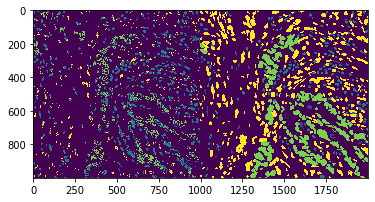

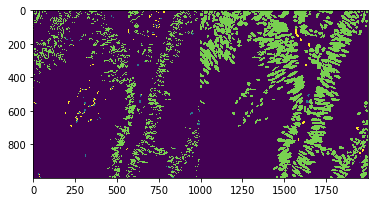

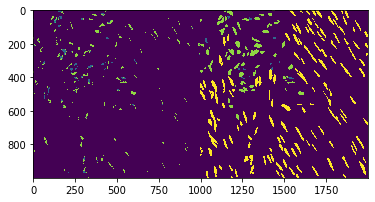

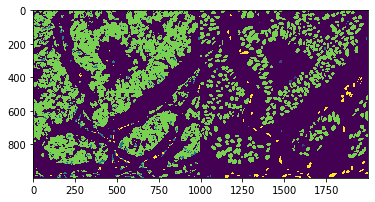

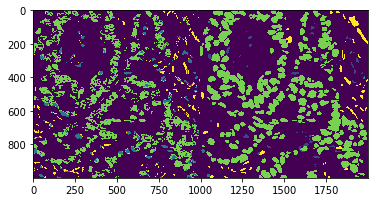

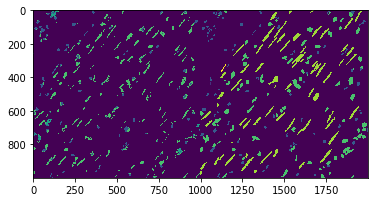

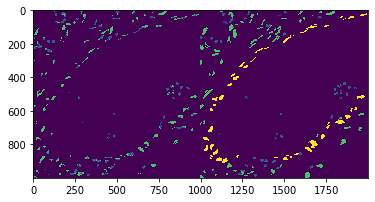

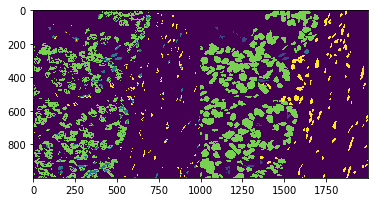

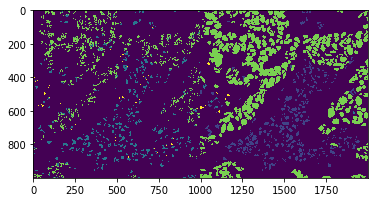

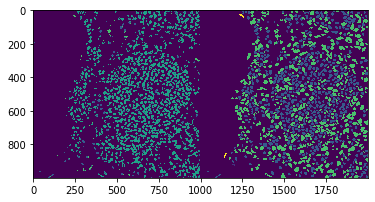

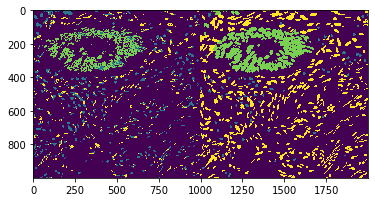

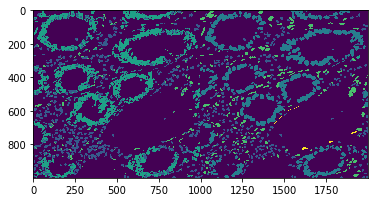

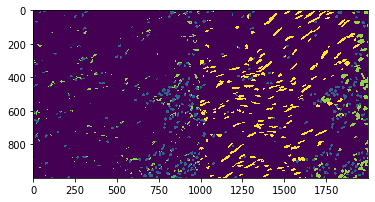

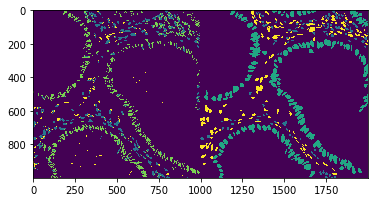

ValueError: ignored

In [ ]:
model.load_state_dict(torch.load(drivePath + 'unet-baseline.pt'))

test_loss, test_acc, test_stats = evaluate(model, test_generator, criterion, demo = True)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')